In [1]:
from collections import deque
from copy import deepcopy

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
from torch.utils.data import DataLoader

In [2]:
SEED = 1
BATCH_SIZE = 64
LR = 0.03
EPOCHS = 4
ALPHA = 0.0001
CLIP = 0.1
GAMMA = 0.99
LAMBDA = 0.95
ENT_COEF = 0.01

# set device
use_cuda = torch.cuda.is_available()
print('cuda:', use_cuda)
device = torch.device('cuda' if use_cuda else 'cpu')

# random seed
np.random.seed(SEED)
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed_all(SEED)

cuda: True


In [3]:
class ActorCriticNet(nn.Module):
    def __init__(self, obs_space, action_space):
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(obs_space, 256),
            nn.SELU()
        )

        self.pol = nn.Sequential(
            nn.Linear(256, 256),
            nn.SELU(),
            nn.Linear(256, action_space)
        )
        
        self.val = nn.Sequential(
            nn.Linear(256, 256),
            nn.SELU(),
            nn.Linear(256, 1)
        )
        
        self.log_softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        out = self.head(x)
        logit = self.pol(out).reshape(out.shape[0], -1)
        value = self.val(out).reshape(out.shape[0], 1)
        log_probs = self.log_softmax(logit)
        
        return log_probs, value

In [4]:
losses = []


def learn(net, old_net, optimizer, train_memory):
    global action_space

    net.train()
    old_net.train()
    for i in range(EPOCHS):
        dataloader = DataLoader(train_memory,
                                batch_size=BATCH_SIZE,
                                shuffle=True,
                                pin_memory=use_cuda)
        for (s, a, adv) in dataloader:
            s_batch = s.to(device).float()
            a_batch = a.detach().to(device).long()
            adv_batch = adv.to(device).float()

            with torch.no_grad():
                log_p_batch_old, v_batch_old = old_net(s_batch)
                log_p_acting_old = log_p_batch_old[range(BATCH_SIZE), a_batch]

            log_p_batch, v_batch = net(s_batch)
            log_p_acting = log_p_batch[range(BATCH_SIZE), a_batch]

            p_ratio = (log_p_acting - log_p_acting_old).exp()
            p_ratio_clip = torch.clamp(p_ratio, 1 - CLIP, 1 + CLIP)
            clip_loss = torch.min(p_ratio * adv_batch,
                                  p_ratio_clip * adv_batch)

            v_loss = (v_batch - v_batch_old).pow(2)
            entropy = -(log_p_batch.exp() * log_p_batch).sum()

            # loss
            loss = -(clip_loss - v_loss + ENT_COEF * entropy).mean()
            losses.append(loss)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


def get_action_and_value(obs, old_net):
    old_net.eval()
    with torch.no_grad():
        state = torch.tensor([obs]).to(device).float()
        log_p, v = old_net(state)
        m = Categorical(log_p.exp())
        action = m.sample()

    return action.item(), v.item()


def compute_adv(rewards, values, roll_memory):
    rew = np.array(rewards, 'float')
    val = np.array(values[:-1], 'float')
    _val = np.array(values[1:], 'float')
    delta = rew + 0.99 * _val - val
    disc_dt = np.array(
        [(GAMMA * LAMBDA)**(i) * dt for i, dt in enumerate(delta.tolist())],
        'float')
    for i, data in enumerate(roll_memory):
        data.append(sum(disc_dt[i:]/(GAMMA * LAMBDA)**(i)))

    return roll_memory

## Main

In [5]:
# make an environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
env = gym.make('MountainCar-v0')
# env = gym.make('LunarLander-v2')

env.seed(SEED)
obs_space = env.observation_space.shape[0]
action_space = env.action_space.n

# hyperparameter
n_episodes = 1000
roll_len = 256
n_eval = env.spec.trials

# global values
steps = 0
learn_steps = 0
ep_rewards = []
reward_eval = deque(maxlen=n_eval)
is_rollout = False
is_solved = False

# make nerual networks
net = ActorCriticNet(obs_space, action_space).to(device)
old_net = deepcopy(net)

# make a optimizer
optimizer = optim.Adam(net.parameters(), lr=LR)

# make a rollout memory
train_memory = []
roll_memory = []
rewards = []
values = []

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [6]:
use_cuda

True

In [7]:
env.spec.max_episode_steps

200

In [8]:
env.spec.trials

100

In [9]:
env.spec.reward_threshold

-110.0

In [10]:
# play
for i in range(1, n_episodes + 1):
    obs = env.reset()
    done = False
    ep_reward = 0
    while not done:
        env.render()

        action, value = get_action_and_value(obs, old_net)
        _obs, reward, done, _ = env.step(action)
        
        # store
        roll_memory.append([obs,action])
        rewards.append(reward)
        values.append(value)
        
        obs = _obs
        steps += 1
        ep_reward += reward
        
        if done or steps % roll_len == 0:
            _, _value = get_action_and_value(_obs, old_net)
            values.append(_value)
            train_memory.extend(compute_adv(rewards, values, roll_memory))
            rewards.clear()
            values.clear()
            roll_memory.clear()
            
        if steps % roll_len == 0:
#             print('\n============  Start Learning  ============\n')
            learn(net, old_net, optimizer, train_memory)
            learn_steps += 1
            train_memory.clear()

        if learn_steps > 1:
            old_net.load_state_dict(net.state_dict())
            learn_steps = 1
    
    if done:        
        ep_rewards.append(ep_reward)
        print('{:3} Episode in {:5} steps, reward {:.2f}'.format(
            i, steps, ep_reward))

        if len(ep_rewards) >= n_eval:
            if np.mean(list(reversed(ep_rewards))[: n_eval]) >= env.spec.reward_threshold:
                print('\n{} is sloved! {:3} Episode in {:3} steps'.format(
                    env.spec.id, i, steps))
                torch.save(old_net.state_dict(),
                           f'./test/saved_models/{env.spec.id}_ep{i}_clear_model_ppo.pt')
                break
env.close()

  1 Episode in   200 steps, reward -200.00
  2 Episode in   400 steps, reward -200.00
  3 Episode in   600 steps, reward -200.00
  4 Episode in   800 steps, reward -200.00
  5 Episode in  1000 steps, reward -200.00
  6 Episode in  1200 steps, reward -200.00
  7 Episode in  1400 steps, reward -200.00
  8 Episode in  1600 steps, reward -200.00
  9 Episode in  1800 steps, reward -200.00
 10 Episode in  2000 steps, reward -200.00
 11 Episode in  2200 steps, reward -200.00
 12 Episode in  2400 steps, reward -200.00
 13 Episode in  2600 steps, reward -200.00
 14 Episode in  2800 steps, reward -200.00
 15 Episode in  3000 steps, reward -200.00
 16 Episode in  3200 steps, reward -200.00
 17 Episode in  3400 steps, reward -200.00
 18 Episode in  3600 steps, reward -200.00
 19 Episode in  3800 steps, reward -200.00
 20 Episode in  4000 steps, reward -200.00
 21 Episode in  4200 steps, reward -200.00
 22 Episode in  4400 steps, reward -200.00
 23 Episode in  4600 steps, reward -200.00
 24 Episode

192 Episode in 38400 steps, reward -200.00
193 Episode in 38600 steps, reward -200.00
194 Episode in 38800 steps, reward -200.00
195 Episode in 39000 steps, reward -200.00
196 Episode in 39200 steps, reward -200.00
197 Episode in 39400 steps, reward -200.00
198 Episode in 39600 steps, reward -200.00
199 Episode in 39800 steps, reward -200.00
200 Episode in 40000 steps, reward -200.00
201 Episode in 40200 steps, reward -200.00
202 Episode in 40400 steps, reward -200.00
203 Episode in 40600 steps, reward -200.00
204 Episode in 40800 steps, reward -200.00
205 Episode in 41000 steps, reward -200.00
206 Episode in 41200 steps, reward -200.00
207 Episode in 41400 steps, reward -200.00
208 Episode in 41600 steps, reward -200.00
209 Episode in 41800 steps, reward -200.00
210 Episode in 42000 steps, reward -200.00
211 Episode in 42200 steps, reward -200.00
212 Episode in 42400 steps, reward -200.00
213 Episode in 42600 steps, reward -200.00
214 Episode in 42800 steps, reward -200.00
215 Episode

383 Episode in 76600 steps, reward -200.00
384 Episode in 76800 steps, reward -200.00
385 Episode in 77000 steps, reward -200.00
386 Episode in 77200 steps, reward -200.00
387 Episode in 77400 steps, reward -200.00
388 Episode in 77600 steps, reward -200.00
389 Episode in 77800 steps, reward -200.00
390 Episode in 78000 steps, reward -200.00
391 Episode in 78200 steps, reward -200.00
392 Episode in 78400 steps, reward -200.00
393 Episode in 78600 steps, reward -200.00
394 Episode in 78800 steps, reward -200.00
395 Episode in 79000 steps, reward -200.00
396 Episode in 79200 steps, reward -200.00
397 Episode in 79400 steps, reward -200.00
398 Episode in 79600 steps, reward -200.00
399 Episode in 79800 steps, reward -200.00
400 Episode in 80000 steps, reward -200.00
401 Episode in 80200 steps, reward -200.00
402 Episode in 80400 steps, reward -200.00
403 Episode in 80600 steps, reward -200.00
404 Episode in 80800 steps, reward -200.00
405 Episode in 81000 steps, reward -200.00
406 Episode

572 Episode in 114400 steps, reward -200.00
573 Episode in 114600 steps, reward -200.00
574 Episode in 114800 steps, reward -200.00
575 Episode in 115000 steps, reward -200.00
576 Episode in 115200 steps, reward -200.00
577 Episode in 115400 steps, reward -200.00
578 Episode in 115600 steps, reward -200.00
579 Episode in 115800 steps, reward -200.00
580 Episode in 116000 steps, reward -200.00
581 Episode in 116200 steps, reward -200.00
582 Episode in 116400 steps, reward -200.00
583 Episode in 116600 steps, reward -200.00
584 Episode in 116800 steps, reward -200.00
585 Episode in 117000 steps, reward -200.00
586 Episode in 117200 steps, reward -200.00
587 Episode in 117400 steps, reward -200.00
588 Episode in 117600 steps, reward -200.00
589 Episode in 117800 steps, reward -200.00
590 Episode in 118000 steps, reward -200.00
591 Episode in 118200 steps, reward -200.00
592 Episode in 118400 steps, reward -200.00
593 Episode in 118600 steps, reward -200.00
594 Episode in 118800 steps, rew

759 Episode in 151800 steps, reward -200.00
760 Episode in 152000 steps, reward -200.00
761 Episode in 152200 steps, reward -200.00
762 Episode in 152400 steps, reward -200.00
763 Episode in 152600 steps, reward -200.00
764 Episode in 152800 steps, reward -200.00
765 Episode in 153000 steps, reward -200.00
766 Episode in 153200 steps, reward -200.00
767 Episode in 153400 steps, reward -200.00
768 Episode in 153600 steps, reward -200.00
769 Episode in 153800 steps, reward -200.00
770 Episode in 154000 steps, reward -200.00
771 Episode in 154200 steps, reward -200.00
772 Episode in 154400 steps, reward -200.00
773 Episode in 154600 steps, reward -200.00
774 Episode in 154800 steps, reward -200.00
775 Episode in 155000 steps, reward -200.00
776 Episode in 155200 steps, reward -200.00
777 Episode in 155400 steps, reward -200.00
778 Episode in 155600 steps, reward -200.00
779 Episode in 155800 steps, reward -200.00
780 Episode in 156000 steps, reward -200.00
781 Episode in 156200 steps, rew

946 Episode in 189200 steps, reward -200.00
947 Episode in 189400 steps, reward -200.00
948 Episode in 189600 steps, reward -200.00
949 Episode in 189800 steps, reward -200.00
950 Episode in 190000 steps, reward -200.00
951 Episode in 190200 steps, reward -200.00
952 Episode in 190400 steps, reward -200.00
953 Episode in 190600 steps, reward -200.00
954 Episode in 190800 steps, reward -200.00
955 Episode in 191000 steps, reward -200.00
956 Episode in 191200 steps, reward -200.00
957 Episode in 191400 steps, reward -200.00
958 Episode in 191600 steps, reward -200.00
959 Episode in 191800 steps, reward -200.00
960 Episode in 192000 steps, reward -200.00
961 Episode in 192200 steps, reward -200.00
962 Episode in 192400 steps, reward -200.00
963 Episode in 192600 steps, reward -200.00
964 Episode in 192800 steps, reward -200.00
965 Episode in 193000 steps, reward -200.00
966 Episode in 193200 steps, reward -200.00
967 Episode in 193400 steps, reward -200.00
968 Episode in 193600 steps, rew

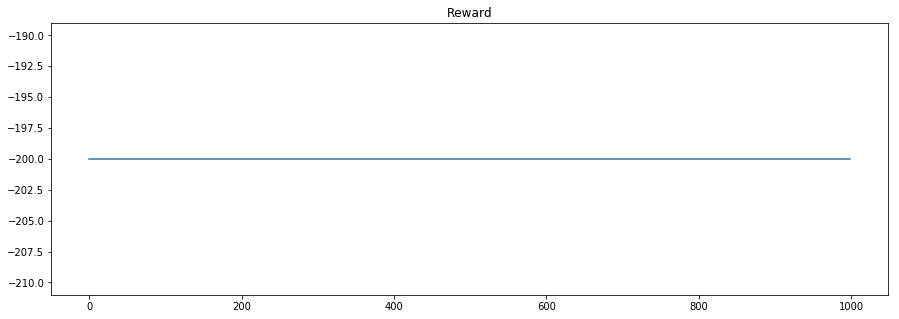

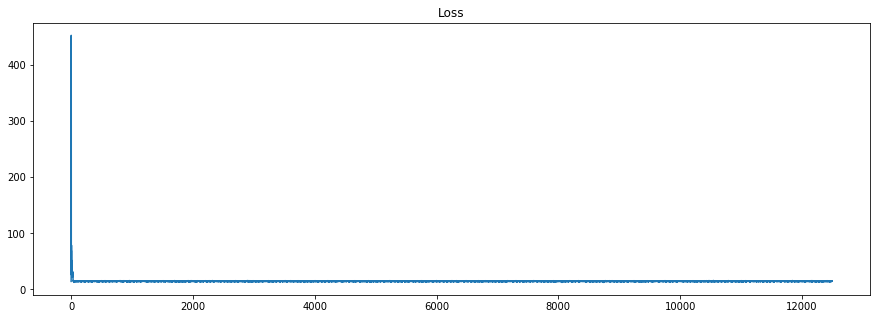

In [11]:
plt.figure(figsize=(15, 5))
plt.title('Reward')
plt.plot(ep_rewards)
plt.figure(figsize=(15, 5))
plt.title('Loss')
plt.plot(losses)
plt.show()

In [12]:
[
    ('CartPole-v0', 126, 16, 128),
    ('CartPole-v1', 225, 64, 256),
    ('MountainCar-v0', 660),
    ('LunarLander-v2', 260)
]

[('CartPole-v0', 126, 16, 128),
 ('CartPole-v1', 225, 64, 256),
 ('MountainCar-v0', 660),
 ('LunarLander-v2', 260)]